In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib import rc

from onepower import Spectra
from params_benchmark import kwargs
from benchmarking import OnepowerBenchmark

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

plt.rcParams.update({'font.size': 16})

spectra_types = ['mm', 'gg', 'gm']

spec_names = {
    'mm': '$\mathrm{Matter-Matter}$',
    'gg': '$\mathrm{Galaxy-Galaxy}$',
    'gm': '$\mathrm{Galaxy-Matter}$'}

/Users/ferreirat/.pyenv/versions/cosmosis/lib/python3.11/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion


#### Load high precision parameter files

In [2]:
with open('mass_high_resolution_benchmark.pkl', 'rb') as f:
    benchmark_ref_mass = pickle.load(f)

with open('k_high_resolution_benchmark.pkl', 'rb') as f:
    benchmark_ref_k = pickle.load(f)

with open('high_resolution_benchmark.pkl', 'rb') as f:
    benchmark_simpson = pickle.load(f)

with open('trapezoid_high_resolution_benchmark.pkl', 'rb') as f:
    benchmark_trapezoid = pickle.load(f)

#
## Power Spectrum

### Mass

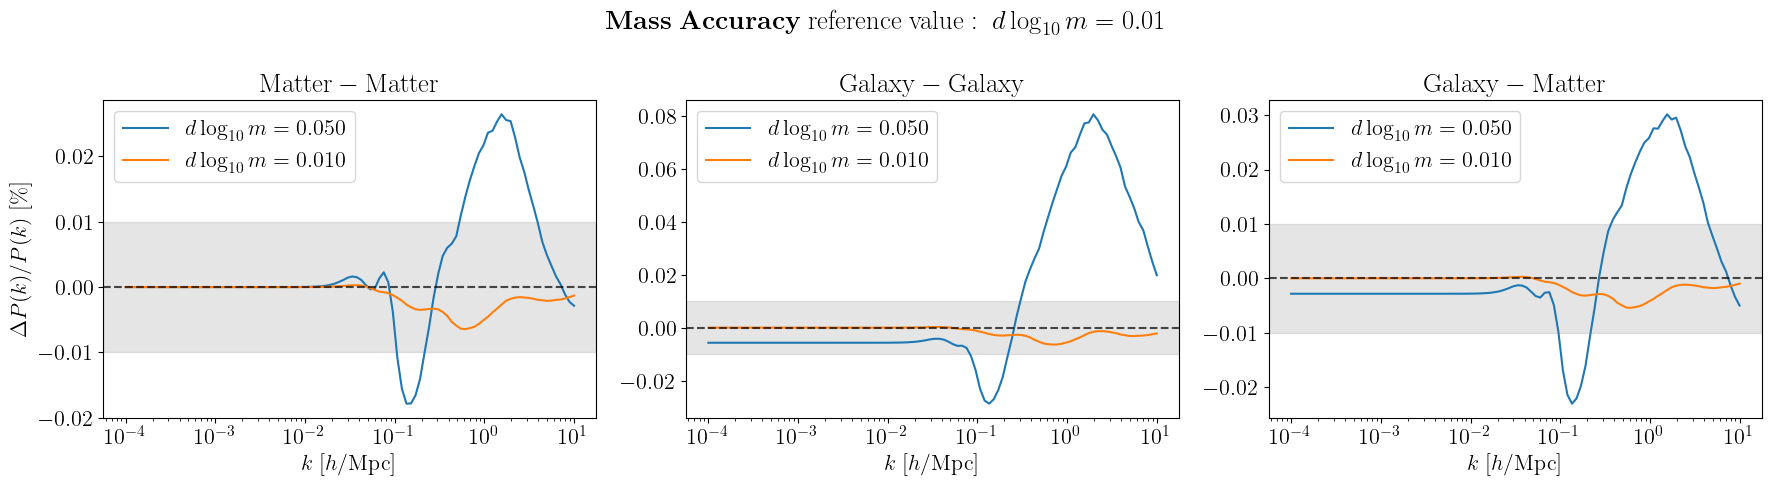

In [3]:
dlog10m_ref = benchmark_ref_mass['params']['dlog10m']

benchmark = OnepowerBenchmark(kwargs)
dlog10m_values = [0.05, 0.01]
mass_results = benchmark.test_mass(
                dlog10m_values=dlog10m_values, 
                spectra_types=spectra_types)

k_vec = benchmark_ref_mass['k_vec']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, spec_type in enumerate(spectra_types):
    ax = axes[idx]

    ref_pk = benchmark_ref_mass['spectra_results'][spec_type]['pk_tot'][0, 0, :]

    for dlog10m_val in dlog10m_values:
        pk_tot = mass_results[dlog10m_val][spec_type]['pk_tot'][0, 0, :]
        rel_error = (pk_tot - ref_pk) / ref_pk * 100
        ax.semilogx(k_vec, rel_error, label=rf'$d\log_{{10}}m={dlog10m_val:.3f}$')

    ax.axhline(y=0, color='k', linestyle='--', alpha=0.7)
    ax.axhspan(-0.01, 0.01, alpha=0.2, color='gray')
    ax.set(
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        title=rf'{spec_names[spec_type]}')
    ax.legend()

axes[0].set_ylabel(r'$\Delta P(k) / P(k)\ [\%]$')

fig.suptitle(rf'$\mathbf{{Mass\ Accuracy}}\ \mathrm{{reference\ value}}:\ d\log_{{10}}m={dlog10m_ref:.2f}$')

plt.tight_layout()
plt.savefig('Pk_mass_accuracy.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

### Wavenumber

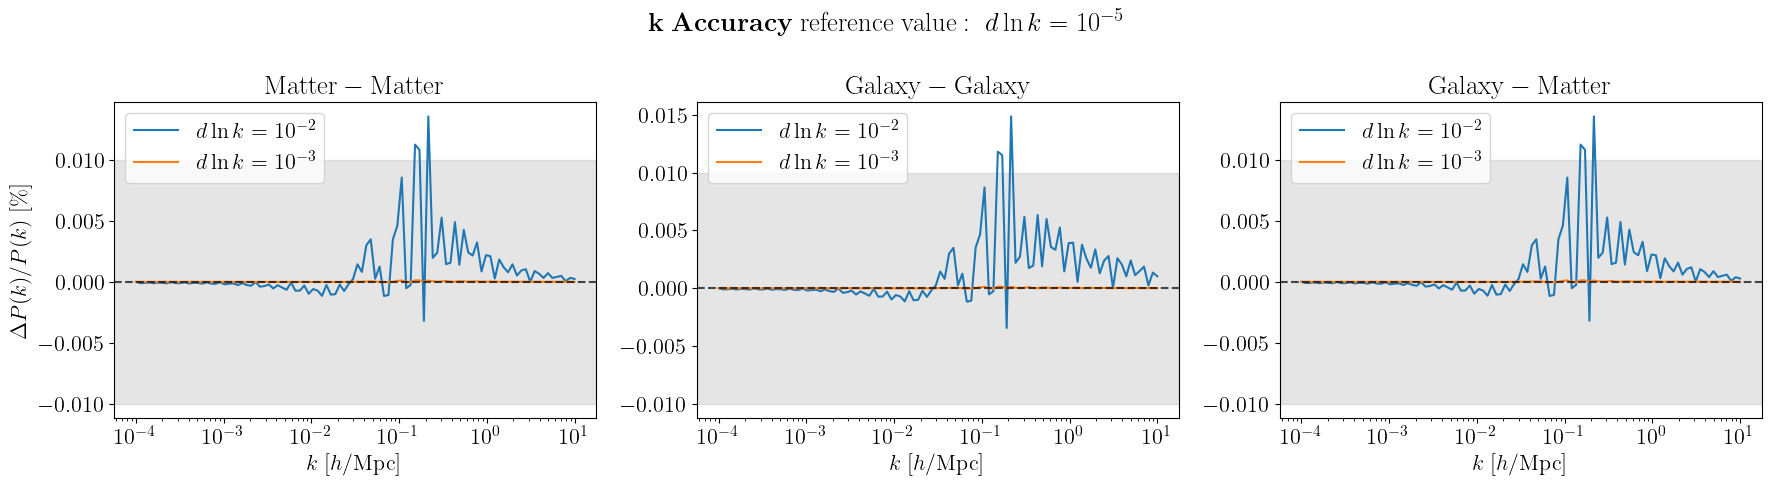

In [4]:
k_ref = benchmark_ref_k['params']['dlnk']
exponent_ref = int(np.log10(k_ref))

benchmark = OnepowerBenchmark(kwargs)
dlnk_values = [0.01, 0.001]
k_results = benchmark.test_k(
                dlnk_values=dlnk_values, 
                spectra_types=spectra_types)

k_vec = benchmark_ref_k['k_vec']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, spec_type in enumerate(spectra_types):
    ax = axes[idx]

    ref_pk = benchmark_ref_k['spectra_results'][spec_type]['pk_tot'][0, 0, :]

    for dlnk_val in dlnk_values:
        pk_tot = k_results[dlnk_val][spec_type]['pk_tot'][0, 0, :]
        rel_error = (pk_tot - ref_pk) / ref_pk * 100
        exponent = int(np.log10(dlnk_val))
        ax.semilogx(k_vec, rel_error, label=rf'$d\ln k=10^{{{exponent}}}$')

    ax.axhline(y=0, color='k', linestyle='--', alpha=0.7)
    ax.axhspan(-0.01, 0.01, alpha=0.2, color='gray')

    ax.set(
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        title=rf'{spec_names[spec_type]}')
    ax.legend()

axes[0].set_ylabel(r'$\Delta P(k) / P(k)\ [\%]$')

fig.suptitle(rf'$\mathbf{{k\ Accuracy}}\ \mathrm{{reference\ value}}:\ d\ln k=10^{{{exponent_ref}}}$')

plt.tight_layout()
plt.savefig('Pk_k_accuracy.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

### Integration method

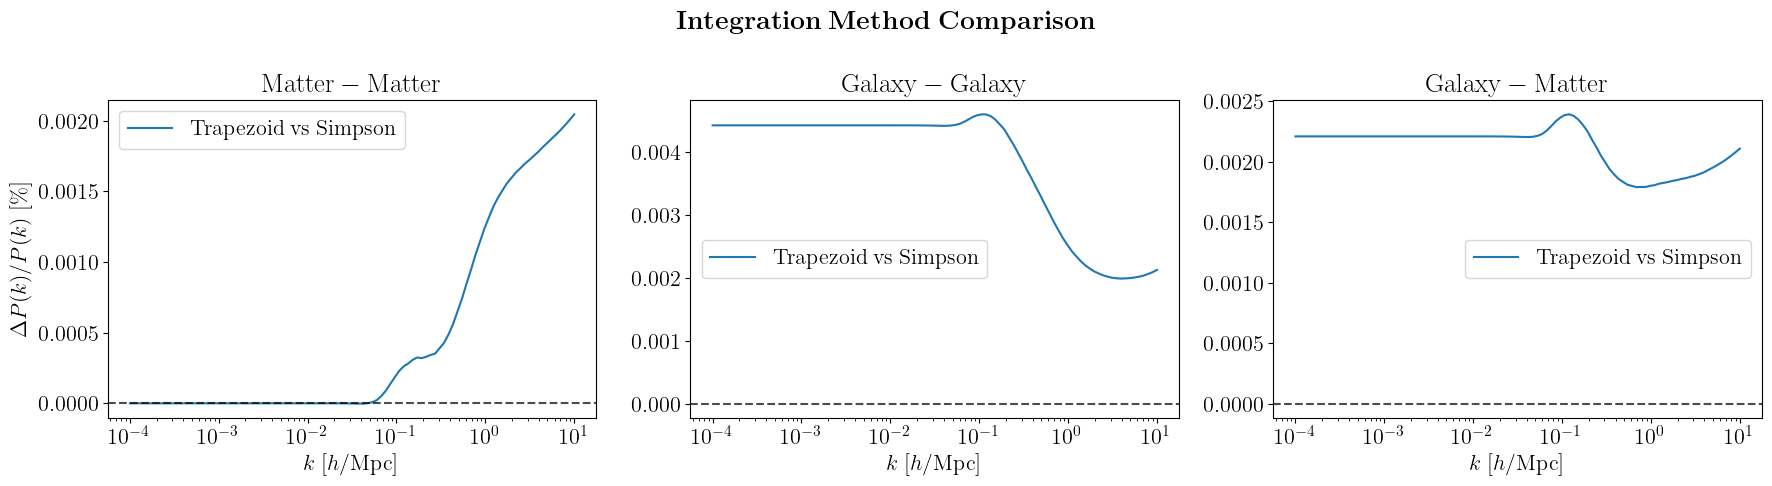

In [5]:
k_vec = benchmark_simpson['k_vec']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, spec_type in enumerate(spectra_types):
    ax = axes[idx]

    simpson_pk = benchmark_simpson['spectra_results'][spec_type]['pk_tot'][0, 0, :]
    trapezoid_pk = benchmark_trapezoid['spectra_results'][spec_type]['pk_tot'][0, 0, :]
    
    rel_error = (trapezoid_pk - simpson_pk) / simpson_pk * 100
    ax.semilogx(k_vec, rel_error, label=r'$\mathrm{Trapezoid\ vs\ Simpson}$')

    ax.axhline(y=0, color='k', linestyle='--', alpha=0.7)
    
    ax.set(
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        title=spec_names[spec_type])
    ax.legend()

axes[0].set_ylabel(r'$\Delta P(k) / P(k)\ [\%]$')

fig.suptitle(r'$\mathbf{Integration\ Method\ Comparison}$')

plt.tight_layout()
plt.savefig('Pk_integration_accuracy.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

#
## Halo Occupation Distribution

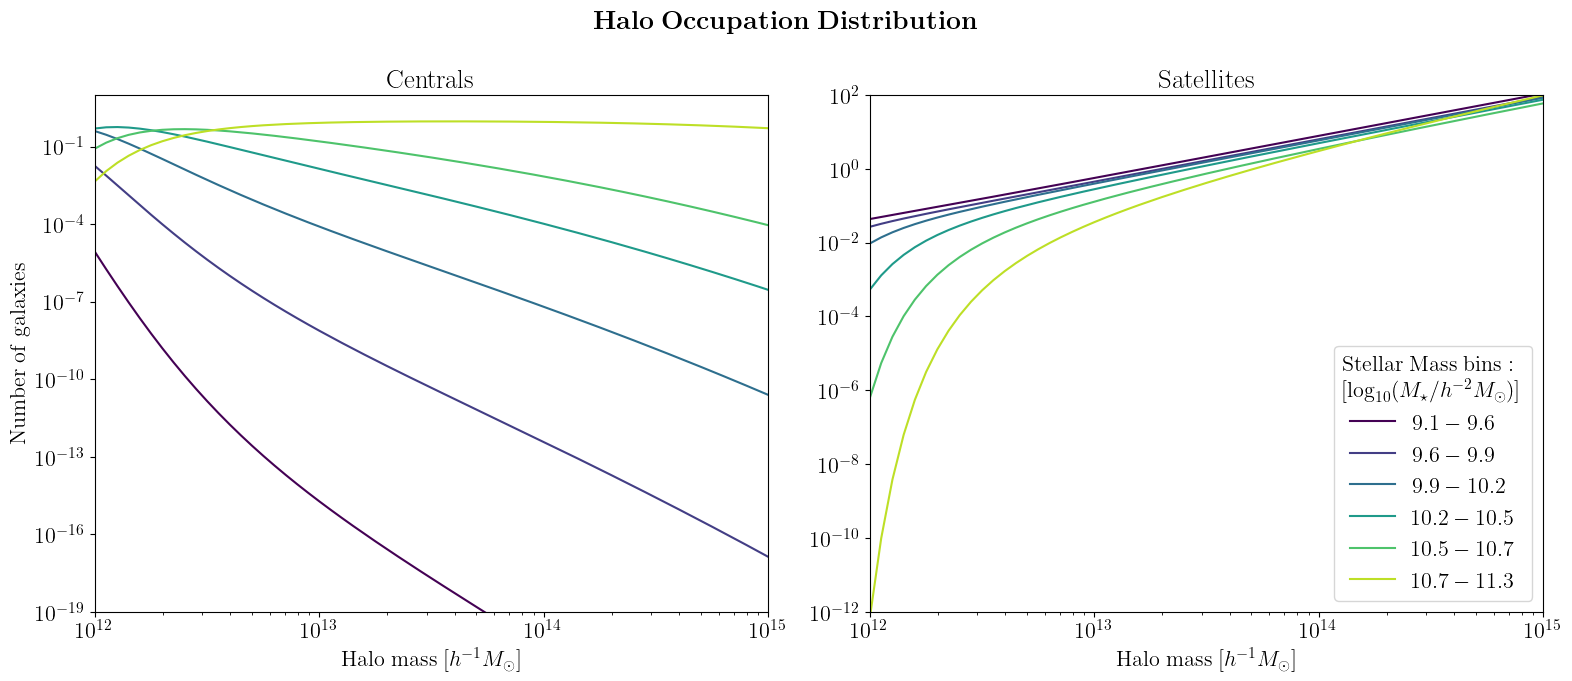

In [6]:
spectra = Spectra(**kwargs)
hod = spectra.hod

nbins = hod.hod_cen.shape[0]
colors = plt.cm.viridis(np.linspace(0, 0.9, nbins))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

obs_min = kwargs['hod_settings']['obs_min']
obs_max = kwargs['hod_settings']['obs_max']

# Centrals
for i in range(nbins):
    ax1.loglog(spectra.mass, hod.hod_cen[i, 0, :],
               color=colors[i])

ax1.set(
    xlabel=r'$\mathrm{Halo\ mass}\ [h^{-1}M_\odot]$',
    ylabel=r'$\mathrm{Number\ of\ galaxies}$',
    title=r'$\mathrm{Centrals}$',
    ylim=[1e-19, 1e1],
    xlim=[1e12, 1e15])

# Satellites
for i in range(nbins):
    label = f'${obs_min[i]:.1f}-{obs_max[i]:.1f}$'
    ax2.loglog(spectra.mass, hod.hod_sat[i, 0, :],
               color=colors[i],
               label=label)

ax2.set(
    xlabel=r'$\mathrm{Halo\ mass}\ [h^{-1}M_\odot]$',
    title=r'$\mathrm{Satellites}$',
    ylim=[1e-12, 1e2],
    xlim=[1e12, 1e15])
ax2.legend(title=r'$\mathrm{Stellar\ Mass\ bins}:$' + '\n' + r'$[\log_{10}(M_\star/h^{-2} M_\odot)]$')

fig.suptitle(r'$\mathbf{Halo\ Occupation\ Distribution}$')

plt.tight_layout()
plt.savefig('HOD.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

/var/folders/pk/12cymqpj2tj_26fx0rkjrmgr0000gt/T/ipykernel_43423/838707501.py:26: RuntimeWarning: invalid value encountered in divide
  rel_error = (hod - ref_hod) / ref_hod * 100


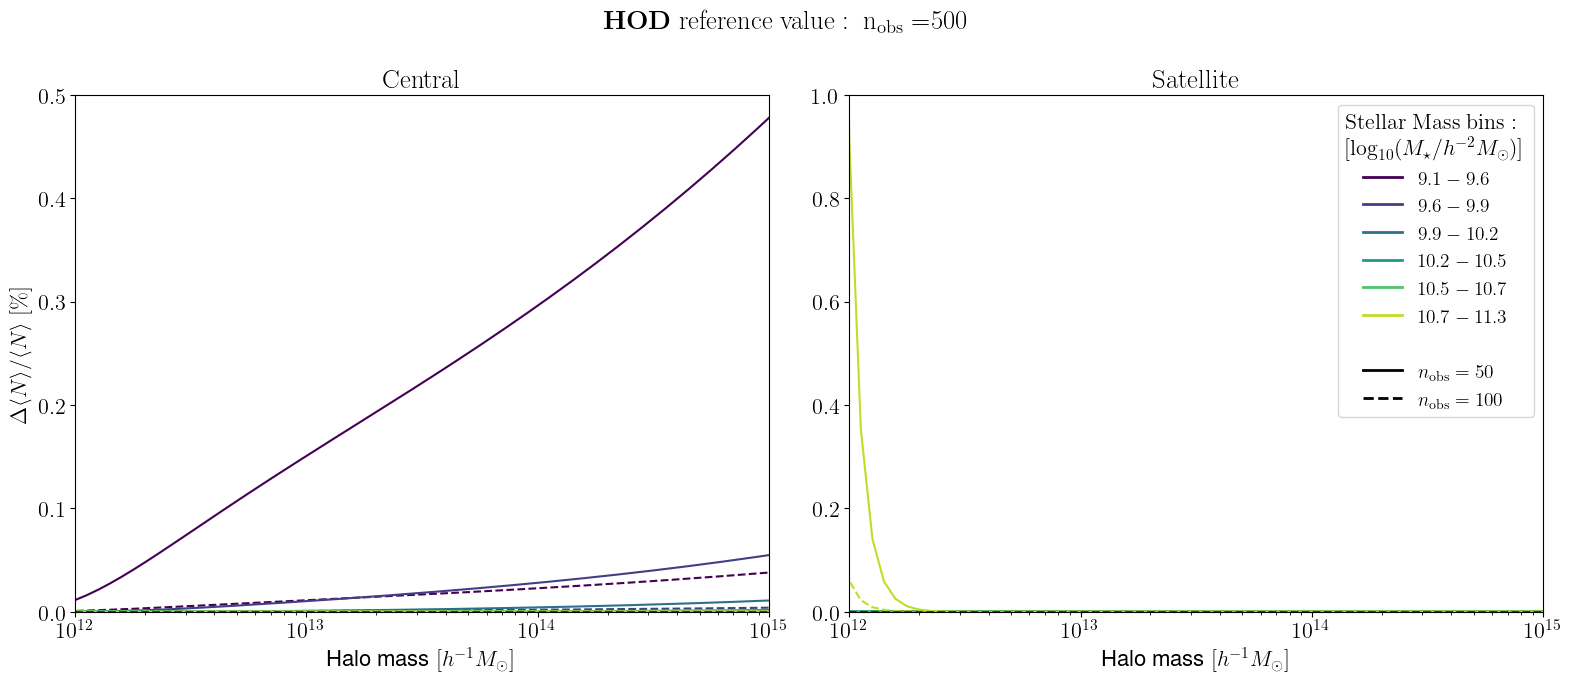

In [ ]:
benchmark = OnepowerBenchmark(kwargs)
nobs_values = [50, 100, 500]
results = benchmark.test_nobs_hod(nobs_values=nobs_values)
ref_nobs = max(nobs_values)

mass = results[ref_nobs]['hod']['mass']
hod_cen = results[ref_nobs]['hod']['hod_cen']
hod_sat = results[ref_nobs]['hod']['hod_sat']

nbins = hod_cen.shape[0]
colors = plt.cm.viridis(np.linspace(0, 0.9, nbins))
linestyles = ['-', '--']

obs_min = kwargs['hod_settings']['obs_min']
obs_max = kwargs['hod_settings']['obs_max']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

for ax, hod_type, title in [(ax1, 'hod_cen', 'Central'), (ax2, 'hod_sat', 'Satellite')]:
    for bin_idx in range(nbins):
        ref_hod = results[ref_nobs]['hod'][hod_type][bin_idx, 0, :]
        
        for j, nobs_val in enumerate(nobs_values):
            if nobs_val != ref_nobs:
                hod = results[nobs_val]['hod'][hod_type][bin_idx, 0, :]
                rel_error = (hod - ref_hod) / ref_hod * 100
                ax.semilogx(mass, rel_error, color=colors[bin_idx], 
                           linestyle=linestyles[j])
    
    ax.set(
        title=rf'$\mathrm{{{title}}}$',
        xlabel=r'Halo mass $[h^{-1}M_\odot]$',
        xlim=[1e12, 1e15])
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.7)

ax2.set_ylim([0,1])
ax1.set(ylim=[0,0.5],
        ylabel=r'$\Delta \langle N \rangle / \langle N \rangle \ [\%]$')

# Create custom legends
bin_legend_elements = [Line2D([0], [0], color=colors[i], lw=2, 
                              label=f'${obs_min[i]:.1f}-{obs_max[i]:.1f}$') 
                       for i in range(nbins)]
separator = [Rectangle((0, 0), 1, 1, fc='w', fill=False, edgecolor='none', linewidth=0, label='')]
 
nobs_legend_elements = [Line2D([0], [0], color='black', linestyle=linestyles[j], lw=2, 
                               label=f'$n_{{\\mathrm{{obs}}}}={nobs_values[j]}$') 
                        for j in range(len(nobs_values)-1)]
all_elements = bin_legend_elements + separator + nobs_legend_elements
ax2.legend(title=r'$\mathrm{Stellar\ Mass\ bins}:$' + '\n' + r'$[\log_{10}(M_\star/h^{-2} M_\odot)]$',
           handles=all_elements, loc='upper right', fontsize=14)

fig.suptitle(rf'$\mathbf{{HOD}}\ \mathrm{{reference\ value:\ n_{{obs}}=}}{ref_nobs}$')

plt.tight_layout()
plt.savefig('HOD_nobs_accuracy.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

#
## Stellar Mass Function

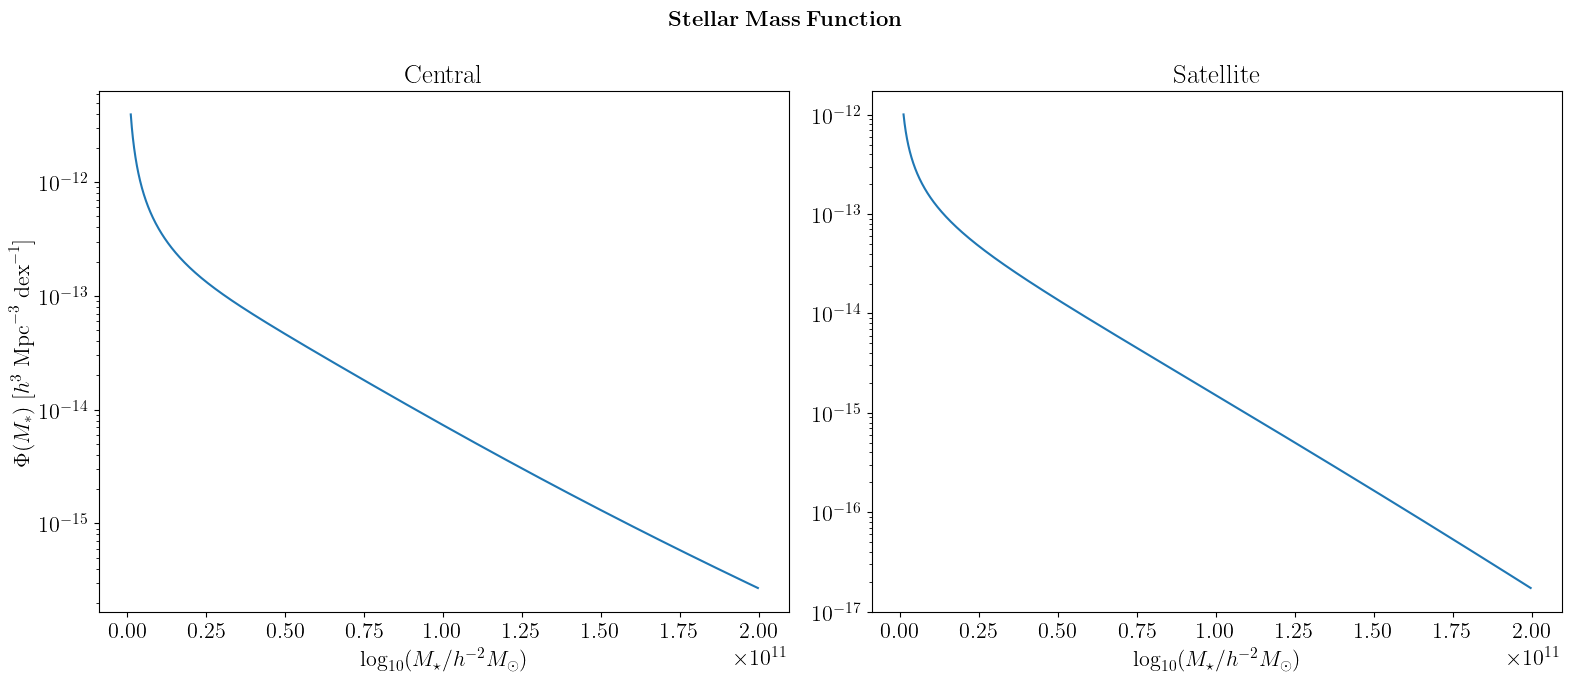

In [8]:
spectra = Spectra(**kwargs)
obs = spectra.obs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Centrals
ax1.semilogy(obs.obs[0, 0, 0, :], obs.obs_func_cen[0, 0, :])
ax1.set(
    xlabel=r'$\log_{10}(M_\star/h^{-2} M_\odot)$',
    ylabel=r'$\Phi(M_*)\ [h^3\ \mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1}]$',
    title=r'$\mathrm{Central}$')

# Satellites
ax2.semilogy(obs.obs[0, 0, 0, :], obs.obs_func_sat[0, 0, :])
ax2.set(
    xlabel=r'$\log_{10}(M_\star/h^{-2} M_\odot)$',
    title=r'$\mathrm{Satellite}$')

fig.suptitle(r'$\mathbf{Stellar\ Mass\ Function}$', fontsize=16)

plt.tight_layout()
plt.savefig('SMF.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

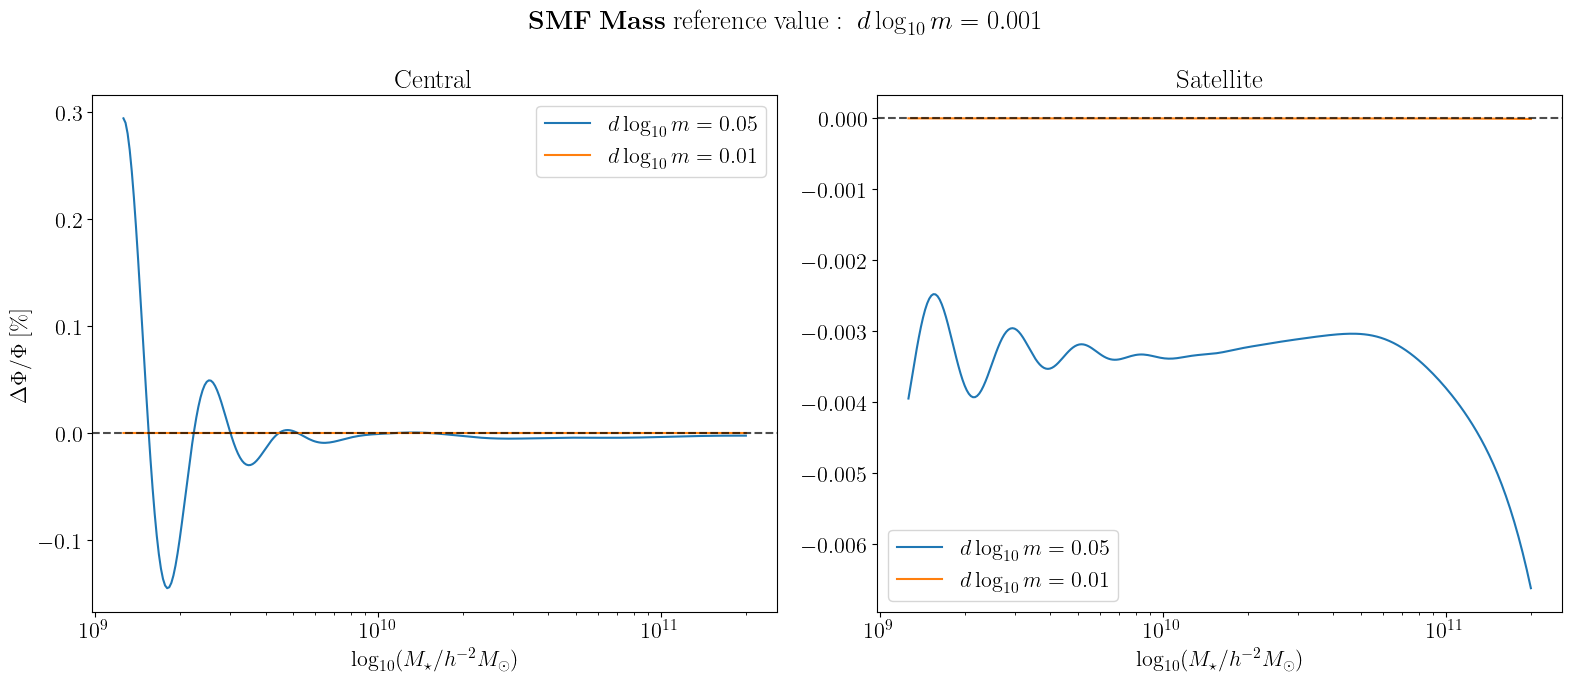

In [9]:
benchmark = OnepowerBenchmark(kwargs)

dlog10m_values = [0.05, 0.01, 0.001]
results = benchmark.test_mass_smf(dlog10m_values=dlog10m_values)
ref_smf = results[dlog10m_values[-1]]['smf']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

for ax, smf_type, title in [(ax1, 'smf_cen', 'Central'), (ax2, 'smf_sat', 'Satellite')]:
    for dlog10m_val in dlog10m_values[:-1]:
        smf = results[dlog10m_val]['smf']
        rel_error = (smf[smf_type] - ref_smf[smf_type]) / ref_smf[smf_type] * 100
        ax.semilogx(smf['stellar_mass'], rel_error, label=rf'$d\log_{{10}}m={dlog10m_val:.2f}$')
    
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.7)
    ax.set(
        xlabel=r'$\log_{10}(M_\star/h^{-2} M_\odot)$',
        title=rf'$\mathrm{{{title}}}$')
    ax.legend()

ax1.set_ylabel(r'$\Delta \Phi / \Phi\ [\%]$')

fig.suptitle(rf'$\mathbf{{SMF\ Mass}}\ \mathrm{{reference\ value}}:\ d\log_{{10}}m={min(dlog10m_values)}$')

plt.tight_layout()
plt.savefig('SMF_mass_accuracy.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

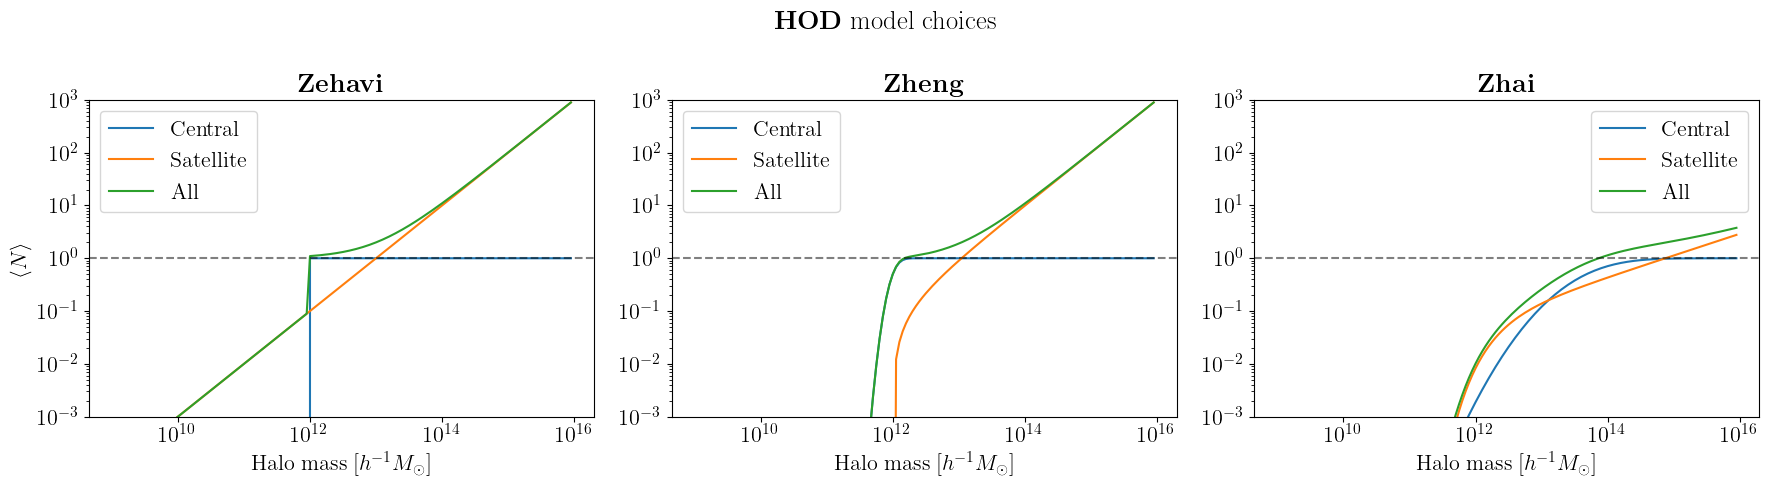

In [17]:
hod_models = ['Zehavi', 'Zheng', 'Zhai']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, hod_model in enumerate(hod_models):
    ax = axes[idx]
    
    spec = Spectra()
    spec.update(hod_model=hod_model)
    
    ax.loglog(spec.mass, spec.hod.hod_cen[0, 0, :], label=r'$\mathrm{Central}$')
    ax.loglog(spec.mass, spec.hod.hod_sat[0, 0, :], label=r'$\mathrm{Satellite}$')
    ax.loglog(spec.mass, spec.hod.hod[0, 0, :], label=r'$\mathrm{All}$')

    ax.axhline(y=1, color='k', linestyle='--', alpha=0.5)
    
    ax.set(
        ylim=[1e-3,1e3],
        xlabel=r'$\mathrm{Halo\ mass}\ [h^{-1}M_\odot]$',
        title=rf'$\mathbf{{{hod_model}}}$')
    ax.legend()

axes[0].set_ylabel(r'$\langle N \rangle$')

fig.suptitle(r'$\mathbf{{HOD}}\ \mathrm{model\ choices}$')

plt.tight_layout()
plt.savefig('HOD_types.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

In [ ]:
spec = Spectra(hod_model='Zehavi')

new_spec = spec



AttributeError: 'Spectra' object has no attribute 'copy'

In [ ]:
hod_models = ['Zehavi', 'Zheng', 'Zhai']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, hod_model in enumerate(hod_models):
    ax = axes[idx]
    
    spec = Spectra()
    spec.update(hod_model=hod_model)
    
    ax.loglog(spec.mass, spec.hod.hod_cen[0, 0, :], label=r'$\mathrm{Central}$')
    ax.loglog(spec.mass, spec.hod.hod_sat[0, 0, :], label=r'$\mathrm{Satellite}$')
    ax.loglog(spec.mass, spec.hod.hod[0, 0, :], label=r'$\mathrm{All}$')

    ax.axhline(y=1, color='k', linestyle='--', alpha=0.5)
    
    ax.set(
        ylim=[1e-3,1e3],
        xlabel=r'$\mathrm{Halo\ mass}\ [h^{-1}M_\odot]$',
        title=rf'$\mathbf{{{hod_model}}}$')
    ax.legend()

axes[0].set_ylabel(r'$\langle N \rangle$')

fig.suptitle(r'$\mathbf{{HOD}}\ \mathrm{model\ choices}$')

plt.tight_layout()
plt.savefig('HOD_types.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()